Ran `MarketPOSCounts` scala script for 08/25 - 09/15. Compile results & analyze markets by POS

b: clean up code & run on all data

Note: this scala script simply counts solutions and shops in eStreaming data by out origin/destination & PCC. No contraints placed on round-trip, passenger type, etc

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

import matplotlib.patches as mpatches
from functools import reduce

In [3]:
APP_NAME = "KF-TopMarketsAnalysis"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.master","yarn"),
        ("spark.driver.memory","10g"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 10),
        ("spark.executor.cores", "5"),
#         ('spark.sql.crossJoin.enabled', True),
#         ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3586'

# load data

In [4]:
inputPath = "/user/kendra.frederick/top_markets/by_pos/"

In [5]:
!hdfs dfs -ls $inputPath > temp.txt

In [6]:
with open('temp.txt') as file:
    tempList = file.readlines()[1:]

pathList = [x.split(" ")[-1].strip() for x in tempList]

In [7]:
df_list = []

for path in pathList:
    date = path.split("/")[-1].rstrip(".csv")
    print(f"Processing {date}")
    try:
        df = spark.read.csv(path + "/", header=True, inferSchema=True)
        df = df.withColumn("searchDt", F.lit(date))
        df_list.append(df)
    except Exception as e:
        print("Womp womp")

Processing 20220825
Processing 20220826
Processing 20220827
Processing 20220828
Processing 20220829
Processing 20220830
Processing 20220831
Processing 20220901
Processing 20220902
Processing 20220903
Processing 20220904
Processing 20220905
Processing 20220906
Processing 20220907
Processing 20220908
Processing 20220909
Processing 20220910
Processing 20220911
Processing 20220912
Processing 20220913
Processing 20220914
Processing 20220915


In [8]:
df_all = reduce(lambda df1, df2: df1.union(df2), df_list)

In [9]:
df_mod = (df_all.drop('outOriginAirport', 'outDestinationAirport', 'pos')
          .withColumnRenamed("originDecoded", "origin")
          .withColumnRenamed("destinationDecoded", "destination")          
          .withColumnRenamed("posDecoded", "pos")
          .select("market", "origin", "destination", "pos", 'num_solutions',
 'num_shops', 'searchDt')
         )

In [10]:
# save to HDFS
df_mod.repartition(25).write.parquet("/user/kendra.frederick/top_markets/summary_by_pos")

In [11]:
df_mod.show(5)

+-------+------+-----------+---+-------------+---------+--------+
| market|origin|destination|pos|num_solutions|num_shops|searchDt|
+-------+------+-----------+---+-------------+---------+--------+
|DME-IST|   DME|        IST| RU|     35296854|   870186|20220825|
|VKO-IST|   VKO|        IST| RU|    325999299|   835741|20220825|
|VKO-SAW|   VKO|        SAW| RU|    159650153|   797141|20220825|
|VKO-AYT|   VKO|        AYT| RU|    230829918|   591566|20220825|
|DME-SAW|   DME|        SAW| RU|      8325634|   565277|20220825|
+-------+------+-----------+---+-------------+---------+--------+
only showing top 5 rows



# Summarize

In [12]:
num_search_days = len(pathList)
num_search_days

22

In [13]:
pos_mrkt_cnts = (df_mod.groupby("pos", "market", "origin", "destination")
                 .agg(
                     F.sum("num_shops").alias("sum_shops"),
                     F.count("searchDt").alias("num_days_searched_for")
                 )
                 .withColumn("avg_shops", F.col("sum_shops") / num_search_days)
                 .withColumn("pct_days_searched_for", 
                             F.col("num_days_searched_for") / num_search_days)
                )

In [14]:
# join w/ aiport lookup to associate country w/ airport
airport_df = spark.read.csv("/user/contentoptimization/reference/content_manager/AIRPORT_FULL.CSV", header=True)

agg_join = (pos_mrkt_cnts
            .join(airport_df.select("airport_code", "country_code"), 
                     on=[pos_mrkt_cnts["origin"] == airport_df["airport_code"]])
            .withColumnRenamed("country_code", "origin_country_code")
            .drop("airport_code")
           )

agg_join = (agg_join.join(airport_df.select("airport_code", "country_code"), 
                     on=[pos_mrkt_cnts["destination"] == airport_df["airport_code"]])
           .withColumnRenamed("country_code", "destination_country_code")
           .drop("airport_code")
          )

# add indicator of whether org &/or dst are in POS country
agg_join = (agg_join
            .withColumn("flight_type", F.when(
                (F.col("origin_country_code") == F.col("pos"))
                & (F.col("destination_country_code") == F.col("pos")), "domestic"
                ).otherwise(F.when(
                (F.col("origin_country_code") != F.col("pos"))
                & (F.col("destination_country_code") != F.col("pos")), "out-of-pos"
                ).otherwise("international"))
           ))

In [15]:
# aggregate again by POS and flight type
pos_cnts_summ = (agg_join
                 .groupby("pos", "flight_type")
                 .agg(
                     F.sum("sum_shops").alias("num_shops"),
                     F.countDistinct("market").alias("num_markets"),
                 )
                 .withColumn("avg_shops", F.col("num_shops") / num_search_days)
                 # should only be ~500 rows at this point
                )#.coalesece(1)

w = Window.partitionBy("pos")
pos_cnts_summ = (pos_cnts_summ
                 .withColumn("pct_pos_shops", F.col("num_shops") / F.sum("num_shops").over(w))
                 .withColumn("pct_pos_markets", 
                             F.col("num_markets") / F.sum("num_markets").over(w))
#                  .withColumn("pct_pos_shops_rounded",
#                                         F.round(F.col("pct_pos_shops")*100, 1)
#                                         )
                )

In [16]:
pos_cnts_summ = pos_cnts_summ.coalesce(1)
pos_cnts_summ.show(5)

+---+-------------+---------+-----------+--------------------+--------------------+--------------------+
|pos|  flight_type|num_shops|num_markets|           avg_shops|       pct_pos_shops|     pct_pos_markets|
+---+-------------+---------+-----------+--------------------+--------------------+--------------------+
| DZ|     domestic|        3|          3| 0.13636363636363635|0.008356545961002786| 0.06666666666666667|
| DZ|          mix|      355|         41|  16.136363636363637|  0.9888579387186629|  0.9111111111111111|
| DZ|international|        1|          1|0.045454545454545456|0.002785515320334262|0.022222222222222223|
| LT|international|    62661|       9144|  2848.2272727272725| 0.26602221203321613|  0.8503673393471589|
| LT|     domestic|      125|          3|   5.681818181818182|5.306773990863858E-4|2.789919092346322E-4|
+---+-------------+---------+-----------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [22]:
flight_type_pdf = pos_cnts_summ.toPandas()

## the final agg

In [17]:
pos_summ = (pos_cnts_summ
            .groupBy("pos")
            .agg(F.sum("num_shops").alias("total_shops"))
            .withColumn('avg_shops', F.col("total_shops") / num_search_days)
           )

w = Window.partitionBy()
pos_summ = pos_summ.withColumn("pct_total_counts", F.col("total_shops") / F.sum("total_shops").over(w))

w2 = (Window
      .orderBy(F.desc("total_shops"))
      .rowsBetween(Window.unboundedPreceding, Window.currentRow)
     )

pos_summ = pos_summ.withColumn("cume_pct", F.sum("pct_total_counts").over(w2)).orderBy(F.desc("total_shops"))

In [18]:
pos_summ_pdf = pos_summ.toPandas()

In [22]:
# pos_summ_pdf.sort_values(by="total_shops", inplace=True, ascending=False)

In [19]:
pos_summ_pdf.head()

,pos,total_shops,avg_shops,pct_total_counts,cume_pct
0,US,2708879486,1.231309e+08,0.254673,0.254673
1,GB,1224429499,5.565589e+07,0.115114,0.369787
2,HK,1128139738,5.127908e+07,0.106061,0.475848
3,IN,720808823,3.276404e+07,0.067766,0.543615
4,DE,716387782,3.256308e+07,0.067351,0.610965


# plots

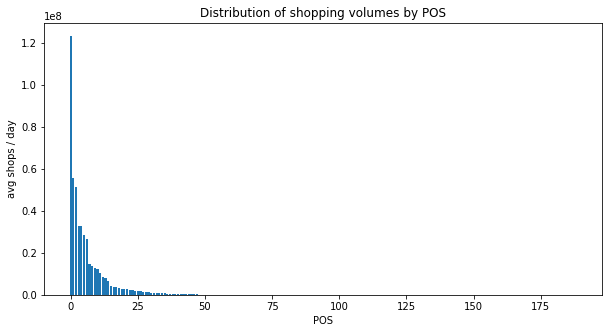

In [24]:
xs = range(len(pos_summ_pdf))
plt.figure(figsize=(10,5))
plt.bar(xs, pos_summ_pdf['avg_shops']);
plt.ylabel("avg shops / day")
plt.xlabel("POS")
plt.title("Distribution of shopping volumes by POS");

In [25]:
print(f"Total number of POS: {len(pos_summ_pdf)}")

Total number of POS: 189


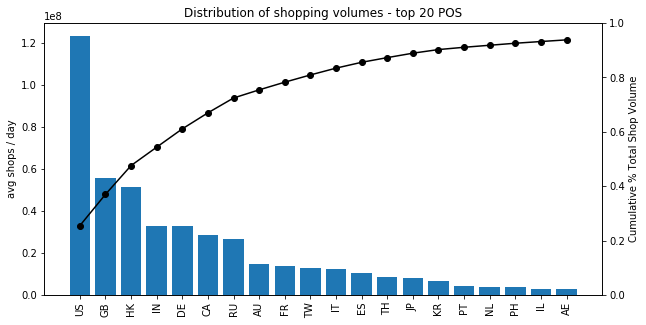

In [27]:
top_n = 20
xs = range(top_n)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(xs, pos_summ_pdf['avg_shops'][:top_n]);
ax.set_xticks(xs)
ax.set_xticklabels(pos_summ_pdf['pos'], rotation=90)
ax.set_ylabel("avg shops / day")

ax2 = ax.twinx()
ax2.plot(xs, pos_summ_pdf['cume_pct'][:top_n], marker="o", color="k")
ax2.set_ylim(0, 1)
ax2.set_ylabel("Cumulative % Total Shop Volume")

plt.title(f"Distribution of shopping volumes - top {top_n} POS");

In [28]:
rank = 20
vol_pct = pos_summ_pdf.loc[rank, 'cume_pct']
print(f"The top {rank} POS's account for {vol_pct*100:.0f}% of the shopping volume")

The top 20 POS's account for 94% of the shopping volume


In [29]:
rank = 10
vol_pct = pos_summ_pdf.loc[rank, 'cume_pct']
print(f"The top {rank} POS's account for {vol_pct*100:.0f}% of the shopping volume")

The top 10 POS's account for 83% of the shopping volume


In [30]:
vol_pct = 0.8
rank = pos_summ_pdf[pos_summ_pdf['cume_pct'] > vol_pct].head(1).index.values[0]
# rank_pct = rank / len(pos_summ_pdf)
print(f"The top {rank} POS's account for {vol_pct*100:.0f}% of the shopping volume")

The top 9 POS's account for 80% of the shopping volume


# look at specific POS

In [33]:
flight_type_pdf.head()

,pos,flight_type,num_shops,num_markets,avg_shops,pct_pos_shops,pct_pos_markets
0,DZ,international,1,1,0.045455,0.002786,0.022222
1,DZ,domestic,3,3,0.136364,0.008357,0.066667
2,DZ,mix,355,41,16.136364,0.988858,0.911111
3,LT,mix,172762,1606,7852.818182,0.733447,0.149354
4,LT,international,62661,9144,2848.227273,0.266022,0.850367


In [ ]:
# flight_type_pdf = flight_type_pdf.drop(columns=["pct_total_shops"])

In [ ]:
flight_type_pdf.sort_values(by="flight_type", inplace=True)

In [ ]:
pos = 'US'
flight_type_pdf[flight_type_pdf['pos'] == pos]

In [ ]:
pos = 'GB'
flight_type_pdf[flight_type_pdf['pos'] == pos]

In [ ]:
pos = 'IN'
flight_type_pdf[flight_type_pdf['pos'] == pos]

In [ ]:
pos = 'CA'
flight_type_pdf[flight_type_pdf['pos'] == pos]

## stacked bar chart

In [20]:
top20_list = list(pos_summ_pdf['pos'][:20])

In [23]:
flight_type_top20 = flight_type_pdf[flight_type_pdf['pos'].isin(top20_list)]

In [28]:
flight_type_top20.head()

,pos,flight_type,num_shops,num_markets,avg_shops,pct_pos_shops,pct_pos_markets
34,NL,international,72463737,243661,3.293806e+06,0.913319,0.982330
35,NL,domestic,1460,8,6.636364e+01,0.000018,0.000032
36,NL,mix,6875941,4375,3.125428e+05,0.086663,0.017638
73,RU,mix,467398683,27704,2.124539e+07,0.805315,0.126977
74,RU,international,78443250,186756,3.565602e+06,0.135156,0.855964


In [29]:
# # rename flight types
# flight_type_top20['flight_type'] = np.where(
#     flight_type_top20['flight_type'] == "international", "out-of-POS",
#         np.where(flight_type_top20['flight_type'] == "mix", "international",
#             flight_type_top20['flight_type']))

In [30]:
flight_type_top20.head()

,pos,flight_type,num_shops,num_markets,avg_shops,pct_pos_shops,pct_pos_markets
34,NL,out-of-POS,72463737,243661,3.293806e+06,0.913319,0.982330
35,NL,domestic,1460,8,6.636364e+01,0.000018,0.000032
36,NL,international,6875941,4375,3.125428e+05,0.086663,0.017638
73,RU,international,467398683,27704,2.124539e+07,0.805315,0.126977
74,RU,out-of-POS,78443250,186756,3.565602e+06,0.135156,0.855964


In [31]:
pvt_vol_pct = flight_type_top20.pivot(index='pos', columns='flight_type', values='pct_pos_shops')
pvt_mrkt_pct = flight_type_top20.pivot(index='pos', columns='flight_type', values='pct_pos_markets')

In [144]:
# import matplotlib.patches as mpatches

In [32]:
pvt_vol_pct = pvt_vol_pct.reset_index().rename_axis(None, axis=1)
pvt_vol_pct['rank'] = pvt_vol_pct['pos'].apply(lambda x: top20_list.index(x))
pvt_vol_pct.sort_values(by='rank', inplace=True)

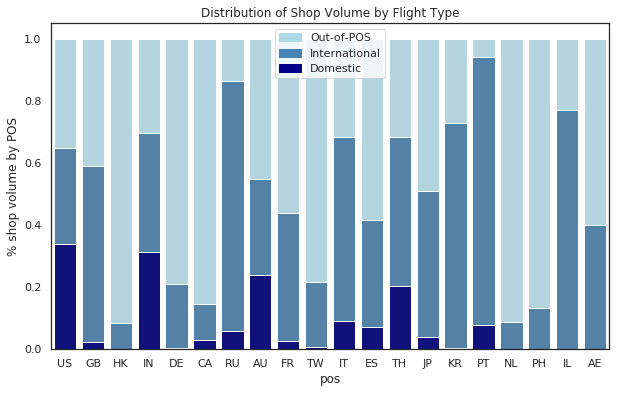

In [33]:
# Ref: https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot
sns.set(style="white")

# set the figure size
plt.figure(figsize=(10, 6))

top_data = np.ones_like(pvt_vol_pct['pos'])
bar1 = sns.barplot(x="pos",  y=top_data, data=pvt_vol_pct, color='lightblue')

middle_data = pvt_vol_pct["domestic"] + pvt_vol_pct["international"]
bar2 = sns.barplot(x=pvt_vol_pct["pos"], y=middle_data, color='steelblue')

bar3 = sns.barplot(x=pvt_vol_pct["pos"], y=pvt_vol_pct["domestic"], color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='Out-of-POS')
middle_bar = mpatches.Patch(color='steelblue', label='International')
bottom_bar = mpatches.Patch(color='darkblue', label='Domestic')
plt.legend(handles=[top_bar, middle_bar, bottom_bar])

# show the graph
plt.title("Distribution of Shop Volume by Flight Type")
plt.ylabel("% shop volume by POS")
plt.show()

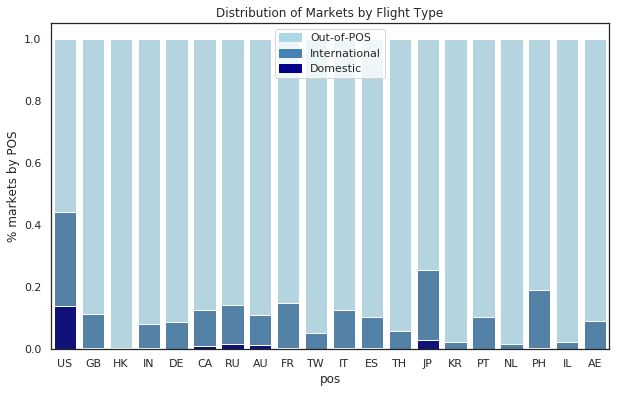

In [36]:
pvt_mrkt_pct =  pvt_mrkt_pct.reset_index().rename_axis(None, axis=1)
pvt_mrkt_pct['rank'] = pvt_mrkt_pct['pos'].apply(lambda x: top20_list.index(x))
pvt_mrkt_pct.sort_values(by='rank', inplace=True)

# Ref: https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot
# sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(10, 6))

top_data = np.ones_like(pvt_mrkt_pct['pos'])
bar1 = sns.barplot(x="pos",  y=top_data, data=pvt_mrkt_pct, color='lightblue')

middle_data = pvt_mrkt_pct["domestic"] + pvt_mrkt_pct["international"]
bar2 = sns.barplot(x=pvt_mrkt_pct["pos"], y=middle_data, color='steelblue')

bar3 = sns.barplot(x=pvt_mrkt_pct["pos"], y=pvt_mrkt_pct["domestic"], color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='Out-of-POS')
middle_bar = mpatches.Patch(color='steelblue', label='International')
bottom_bar = mpatches.Patch(color='darkblue', label='Domestic')
plt.legend(handles=[top_bar, middle_bar, bottom_bar])

# show the graph
plt.title("Distribution of Markets by Flight Type")
plt.ylabel("% markets by POS")
plt.show()